<h1 style="color:blue">Preambule</h1>

<div class="alert alert-block alert-info">
    Due the fact that there aren't too many tutorials that use <b>XBNet</b> (especially about regression with this architecture), i tried to do a simple one.These notebook is about <b>time series forecasting</b> of COVID-19 data from India.
</div>

<h1 style="color:blue">Libraries</h1>

In [1]:
### General ###
import os
import math
import random
import warnings
import numpy as np
import pandas as pd

### Visualization ###
import matplotlib as mpl
from colorama import Fore
import matplotlib.pyplot as plt

### Machine Learning Tools ###
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split

### Deep Learning ###
import torch

<h1 style="color:blue">Configuration</h1>

In [2]:
seed = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(seed)

In [3]:
plt.style.use("bmh")
warnings.filterwarnings("ignore")
mpl.rcParams["agg.path.chunksize"] = 10000

In [4]:
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
m_ = Fore.MAGENTA
r_ = Fore.RED
y_ = Fore.YELLOW

<h1 style="color:blue">Loading and Exploring the Data</h1>

In [5]:
df = pd.read_csv("../input/covid19-in-india/covid_19_india.csv")

# Replaces numerical NaN (NNs are bad with NaNs)
for col in df.columns:
  if df[col].dtype not in [str, object]:
    df[col] = df[col].fillna(0)

df.Date = pd.to_datetime(df.Date, format = "%Y-%m-%d")
df.set_index("Date", drop = False, inplace = True)

In [6]:
df.Date.max()

Timestamp('2021-08-11 00:00:00')

In [7]:
df.Date.min()

Timestamp('2020-01-30 00:00:00')

In [8]:
df.dtypes

Sno                                  int64
Date                        datetime64[ns]
Time                                object
State/UnionTerritory                object
ConfirmedIndianNational             object
ConfirmedForeignNational            object
Cured                                int64
Deaths                               int64
Confirmed                            int64
dtype: object

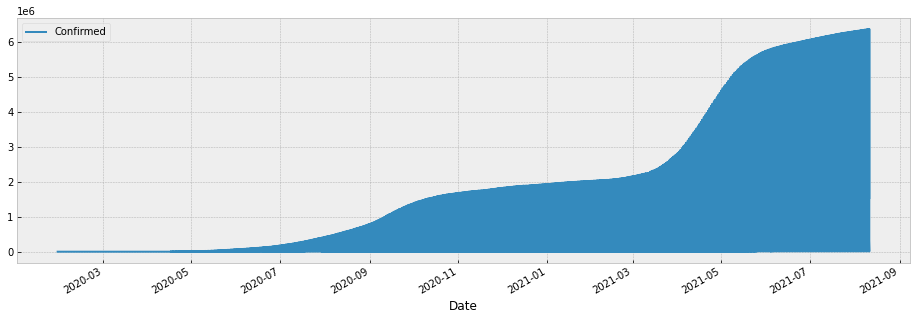

In [9]:
df[["Confirmed"]].plot(figsize = (16, 5));

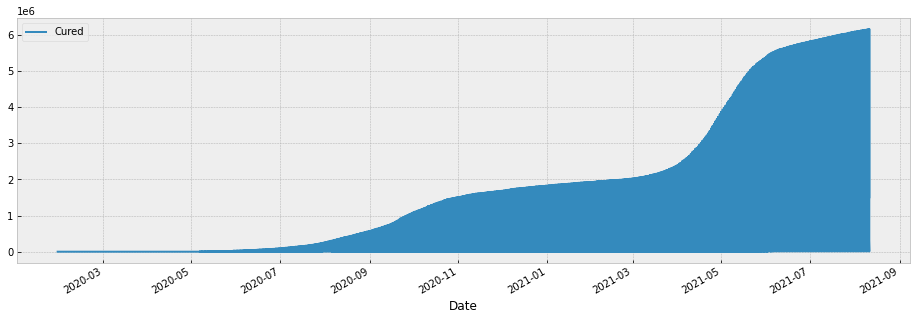

In [10]:
df[["Cured"]].plot(figsize = (16, 5));

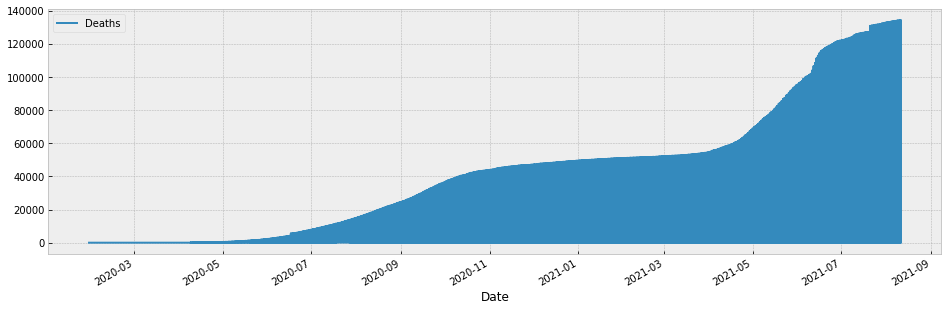

In [11]:
df[["Deaths"]].plot(figsize = (16, 5));

<h2 style="color:red">Spliting the Data</h2>

Test dataset with one month of cases, i tried to avoid **data leakeage** with this.

In [12]:
train = df[df.Date < "2021-07-11"]
test = df[df.Date >= "2021-07-11"]

In [13]:
X = train.drop(["Date", "Time", "State/UnionTerritory", "ConfirmedIndianNational", "ConfirmedForeignNational", "Confirmed"],
                    axis = 1)
y = train["Confirmed"]

X_test = test.drop(["Date", "Time", "State/UnionTerritory", "ConfirmedIndianNational", "ConfirmedForeignNational", "Confirmed"],
                  axis = 1)
y_test = test["Confirmed"]

In [14]:
print(f"{b_}X_train.shape: {r_}{X.shape}")
print(f"{b_}X_test.shape: {r_}{X_test.shape}")
print(f"{b_}y.shape: {r_}{y.shape}")
print(f"{b_}y_test.shape: {r_}{y_test.shape}")

<h2 style="color:red">Re-spliting the Data</h2>

This time is to make a validation dataset, **i don't want to show test data to the model**. Many works that a saw do that to improve their "amazing results".

In [15]:
# Don't shuffle order matters or at least is what i know
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20, random_state = 42, shuffle = False)

<h1 style="color:blue">XGBoost</h1>

In [16]:
%%time
xgb_reg = xgb.XGBRegressor(
    tree_method = "gpu_hist", 
    n_estimators = 200, 
    random_state = 42,
    learning_rate = 0.02,
    max_depth = 20,
    gamma = 0,
    subsample = 1,
    min_child_weight = 1,
    nthread = 4,
    colsample_bytree = 1
)
xgb_reg.fit(
    X_train,
    y_train,
    eval_set = [(X_valid, y_valid)],
    early_stopping_rounds = 10,
    verbose = False
)

CPU times: user 17.9 s, sys: 406 ms, total: 18.3 s
Wall time: 18.8 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)

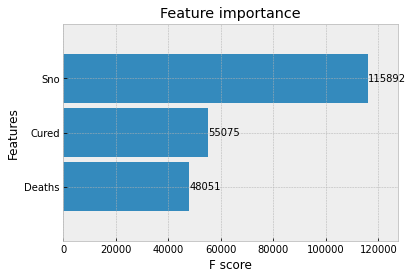

In [17]:
xgb.plot_importance(xgb_reg, height = 0.9);

<h1 style="color:blue">XBNet</h1>

- [Useful example](https://www.kaggle.com/mpwolke/xbnet-creditability)
- [Original paper](https://arxiv.org/abs/2106.05239)
- [GitHub repo](https://github.com/tusharsarkar3/XBNet)

In [18]:
X_train, X_valid = X_train.to_numpy(), X_valid.to_numpy()
y_train, y_valid = y_train.to_numpy(), y_valid.to_numpy()
X_test = X_test.to_numpy()

In [19]:
# Installing XBNet from GitHub
!pip install --upgrade git+https://github.com/tusharsarkar3/XBNet.git

  Cloning https://github.com/tusharsarkar3/XBNet.git to /tmp/pip-req-build-2gi2hkc8
  Running command git clone -q https://github.com/tusharsarkar3/XBNet.git /tmp/pip-req-build-2gi2hkc8
     |████████████████████████████████| 15.7 MB 517 kB/s eta 0:00:01
     |████████████████████████████████| 11.3 MB 59.9 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 45.7 MB/s eta 0:00:01
     |████████████████████████████████| 831.4 MB 1.1 kB/s  eta 0:00:01    |███                             | 77.1 MB 2.0 MB/s eta 0:06:15     |███                             | 78.5 MB 2.0 MB/s eta 0:06:15     |███                             | 80.3 MB 2.0 MB/s eta 0:06:14     |██████▎                         | 162.3 MB 47.7 MB/s eta 0:00:15     |██████████████▏                 | 368.4 MB 30.8 MB/s eta 0:00:16     |██████████████▎                 | 371.5 MB 30.8 MB/s eta 0:00:15     |██████████████▉                 | 384.4 MB 30.8 MB/s eta 0:00:15     |███████████████▊                | 408.8 MB 20.

<h2 style="color:red">Modelling</h2>

~~~
Enter dimensions of linear layers: 
Enter input dimensions of layer 1:  10
Enter output dimensions of layer 1:  10
Set bias as True or False:  False
Enter input dimensions of layer 2:  10
Enter output dimensions of layer 2:  1
Set bias as True or False:  False
Enter your last layer 
1. Sigmoid 
2. Softmax 
3. None 
 3
 ~~~~

In [21]:
from XBNet.run import run_XBNET
from XBNet.models import XBNETRegressor
from XBNet.training_utils import training, predict

model = XBNETRegressor(
    X_train,
    y_train,
    num_layers = 2
)

Enter dimensions of linear layers: 


Enter input dimensions of layer 1:  10
Enter output dimensions of layer 1:  10
Set bias as True or False:  False
Enter input dimensions of layer 2:  10
Enter output dimensions of layer 2:  1
Set bias as True or False:  False


Enter your last layer 


1. Sigmoid 
2. Softmax 
3. None 
 3


In [22]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

<h2 style="color:red">Training</h2>


Percentage training completed:   1%|          | 1/100 [00:10<17:38, 10.70s/it]

Training Loss after epoch 1 is 25995888300.677555 and Accuracy is 95.93150741896098
Validation Loss after epoch 1 is 30242060288.0 and Accuracy is 97.07647386024763


Percentage training completed:   2%|▏         | 2/100 [00:21<17:35, 10.77s/it]

Training Loss after epoch 2 is 642849799.2077777 and Accuracy is 98.69000434874764
Validation Loss after epoch 2 is 8297939968.0 and Accuracy is 99.19091525430674


Percentage training completed:   3%|▎         | 3/100 [00:33<17:57, 11.11s/it]

Training Loss after epoch 3 is 610022755.9888484 and Accuracy is 98.6095250108939
Validation Loss after epoch 3 is 8764847104.0 and Accuracy is 99.14487748587183


Percentage training completed:   4%|▍         | 4/100 [00:43<17:34, 10.98s/it]

Training Loss after epoch 4 is 616386824.3373928 and Accuracy is 98.5522045743821
Validation Loss after epoch 4 is 9118844928.0 and Accuracy is 99.11010455114898


Percentage training completed:   5%|▌         | 5/100 [00:55<17:30, 11.06s/it]

Training Loss after epoch 5 is 616596486.3411819 and Accuracy is 98.51254879215621
Validation Loss after epoch 5 is 9376295936.0 and Accuracy is 99.08487082551116


Percentage training completed:   6%|▌         | 6/100 [01:06<17:21, 11.07s/it]

Training Loss after epoch 6 is 613858696.2893356 and Accuracy is 98.49205114567899
Validation Loss after epoch 6 is 9519493120.0 and Accuracy is 99.07085137628935


Percentage training completed:   7%|▋         | 7/100 [01:16<17:00, 10.97s/it]

Training Loss after epoch 7 is 608753982.0720624 and Accuracy is 98.48959565046013
Validation Loss after epoch 7 is 9550956544.0 and Accuracy is 99.06776993135257


Percentage training completed:   8%|▊         | 8/100 [01:28<17:12, 11.22s/it]

Training Loss after epoch 8 is 601958724.0852723 and Accuracy is 98.50328882282949
Validation Loss after epoch 8 is 9481639936.0 and Accuracy is 99.07454947266784


Percentage training completed:   9%|▉         | 9/100 [01:39<16:48, 11.08s/it]

Training Loss after epoch 9 is 594062884.9735864 and Accuracy is 98.53033578895459
Validation Loss after epoch 9 is 9330481152.0 and Accuracy is 99.08934740448196


Percentage training completed:  10%|█         | 10/100 [01:50<16:27, 10.97s/it]

Training Loss after epoch 10 is 585558672.521173 and Accuracy is 98.56742152450578
Validation Loss after epoch 10 is 9120890880.0 and Accuracy is 99.10989216688597


Percentage training completed:  11%|█         | 11/100 [02:01<16:34, 11.17s/it]

Training Loss after epoch 11 is 576817999.7814486 and Accuracy is 98.61112308349249
Validation Loss after epoch 11 is 8876878848.0 and Accuracy is 99.13385333544579


Percentage training completed:  12%|█▏        | 12/100 [02:12<16:13, 11.06s/it]

Training Loss after epoch 12 is 568102949.9066211 and Accuracy is 98.6583125217704
Validation Loss after epoch 12 is 8619843584.0 and Accuracy is 99.15914983211282


Percentage training completed:  13%|█▎        | 13/100 [02:23<15:54, 10.98s/it]

Training Loss after epoch 13 is 559575483.1190825 and Accuracy is 98.70641032693786
Validation Loss after epoch 13 is 8366580736.0 and Accuracy is 99.18414301271208


Percentage training completed:  14%|█▍        | 14/100 [02:34<15:59, 11.16s/it]

Training Loss after epoch 14 is 551333310.9147733 and Accuracy is 98.75345998839154
Validation Loss after epoch 14 is 8128836608.0 and Accuracy is 99.20768013865127


Percentage training completed:  15%|█▌        | 15/100 [02:45<15:40, 11.07s/it]

Training Loss after epoch 15 is 543425187.7003462 and Accuracy is 98.79814175243132
Validation Loss after epoch 15 is 7913548288.0 and Accuracy is 99.22907315096906


Percentage training completed:  16%|█▌        | 16/100 [02:56<15:21, 10.98s/it]

Training Loss after epoch 16 is 535877350.1023164 and Accuracy is 98.83963938170449
Validation Loss after epoch 16 is 7723940864.0 and Accuracy is 99.24799338112908


Percentage training completed:  17%|█▋        | 17/100 [03:08<15:29, 11.20s/it]

Training Loss after epoch 17 is 528702354.0403248 and Accuracy is 98.87755339248635
Validation Loss after epoch 17 is 7560511488.0 and Accuracy is 99.26437828379083


Percentage training completed:  18%|█▊        | 18/100 [03:19<15:13, 11.14s/it]

Training Loss after epoch 18 is 521905581.8532225 and Accuracy is 98.911769443262
Validation Loss after epoch 18 is 7421990912.0 and Accuracy is 99.27833833893249


Percentage training completed:  19%|█▉        | 19/100 [03:30<14:58, 11.09s/it]

Training Loss after epoch 19 is 515489931.26188856 and Accuracy is 98.94235567636582
Validation Loss after epoch 19 is 7306179072.0 and Accuracy is 99.29007621465539


Percentage training completed:  20%|██        | 20/100 [03:42<15:07, 11.34s/it]

Training Loss after epoch 20 is 509454987.14450777 and Accuracy is 98.96950835633385
Validation Loss after epoch 20 is 7210391040.0 and Accuracy is 99.29984492386906


Percentage training completed:  21%|██        | 21/100 [03:53<14:48, 11.24s/it]

Training Loss after epoch 21 is 503798126.2515329 and Accuracy is 98.99347596714007
Validation Loss after epoch 21 is 7131898368.0 and Accuracy is 99.30790316505323


Percentage training completed:  22%|██▏       | 22/100 [04:04<14:32, 11.18s/it]

Training Loss after epoch 22 is 498514039.64513856 and Accuracy is 99.01453828098568
Validation Loss after epoch 22 is 7068087296.0 and Accuracy is 99.31450062869969


Percentage training completed:  23%|██▎       | 23/100 [04:16<14:39, 11.43s/it]

Training Loss after epoch 23 is 493594340.1119975 and Accuracy is 99.03297898564828
Validation Loss after epoch 23 is 7016593408.0 and Accuracy is 99.31986510910924


Percentage training completed:  24%|██▍       | 24/100 [04:27<14:22, 11.35s/it]

Training Loss after epoch 24 is 489028022.8555788 and Accuracy is 99.0490758874555
Validation Loss after epoch 24 is 6975329792.0 and Accuracy is 99.32419835743711


Percentage training completed:  25%|██▌       | 25/100 [04:38<14:05, 11.28s/it]

Training Loss after epoch 25 is 484800797.7777576 and Accuracy is 99.0630900830492
Validation Loss after epoch 25 is 6942510080.0 and Accuracy is 99.32767410525253


Percentage training completed:  26%|██▌       | 26/100 [04:50<14:08, 11.47s/it]

Training Loss after epoch 26 is 480896822.5902439 and Accuracy is 99.07526039363856
Validation Loss after epoch 26 is 6916630016.0 and Accuracy is 99.33043966079013


Percentage training completed:  27%|██▋       | 27/100 [05:01<13:47, 11.34s/it]

Training Loss after epoch 27 is 477299068.7753519 and Accuracy is 99.08581117522124
Validation Loss after epoch 27 is 6896429056.0 and Accuracy is 99.33261945402148


Percentage training completed:  28%|██▊       | 28/100 [05:13<13:44, 11.45s/it]

Training Loss after epoch 28 is 473988656.1147585 and Accuracy is 99.09494023153493
Validation Loss after epoch 28 is 6880870912.0 and Accuracy is 99.33431629948298


Percentage training completed:  29%|██▉       | 29/100 [05:24<13:23, 11.32s/it]

Training Loss after epoch 29 is 470945207.5314023 and Accuracy is 99.10283473135098
Validation Loss after epoch 29 is 6869097984.0 and Accuracy is 99.33561671470811


Percentage training completed:  30%|███       | 30/100 [05:35<13:06, 11.23s/it]

Training Loss after epoch 30 is 468150209.45001334 and Accuracy is 99.10965329062347
Validation Loss after epoch 30 is 6860409344.0 and Accuracy is 99.33659116367839


Percentage training completed:  31%|███       | 31/100 [05:46<13:04, 11.38s/it]

Training Loss after epoch 31 is 465582751.7764963 and Accuracy is 99.11554403862978
Validation Loss after epoch 31 is 6854237184.0 and Accuracy is 99.33729768378055


Percentage training completed:  32%|███▏      | 32/100 [05:57<12:46, 11.27s/it]

Training Loss after epoch 32 is 463224425.5866934 and Accuracy is 99.12063765490038
Validation Loss after epoch 32 is 6850114048.0 and Accuracy is 99.33778454261038


Percentage training completed:  33%|███▎      | 33/100 [06:08<12:28, 11.17s/it]

Training Loss after epoch 33 is 461056397.1084785 and Accuracy is 99.1250523792225
Validation Loss after epoch 33 is 6847644160.0 and Accuracy is 99.33809289649534


Percentage training completed:  34%|███▍      | 34/100 [06:20<12:26, 11.31s/it]

Training Loss after epoch 34 is 459062071.9573186 and Accuracy is 99.12889149785525
Validation Loss after epoch 34 is 6846525952.0 and Accuracy is 99.33825495273555


Percentage training completed:  35%|███▌      | 35/100 [06:31<12:06, 11.18s/it]

Training Loss after epoch 35 is 457225274.45617497 and Accuracy is 99.13224326228067
Validation Loss after epoch 35 is 6846488064.0 and Accuracy is 99.3382987923799


Percentage training completed:  36%|███▌      | 36/100 [06:42<11:46, 11.04s/it]

Training Loss after epoch 36 is 455530876.3490988 and Accuracy is 99.1351876009263
Validation Loss after epoch 36 is 6847323648.0 and Accuracy is 99.33824725468438


Percentage training completed:  37%|███▋      | 37/100 [06:53<11:43, 11.16s/it]

Training Loss after epoch 37 is 453965894.4721417 and Accuracy is 99.13779558512687
Validation Loss after epoch 37 is 6848846336.0 and Accuracy is 99.3381201147698


Percentage training completed:  38%|███▊      | 38/100 [07:04<11:26, 11.07s/it]

Training Loss after epoch 38 is 452517337.9422293 and Accuracy is 99.14012370974353
Validation Loss after epoch 38 is 6850917376.0 and Accuracy is 99.33793237949597


Percentage training completed:  39%|███▉      | 39/100 [07:15<11:11, 11.01s/it]

Training Loss after epoch 39 is 451175201.57739615 and Accuracy is 99.14222294778419
Validation Loss after epoch 39 is 6853404672.0 and Accuracy is 99.33769831448956


Percentage training completed:  40%|████      | 40/100 [07:26<11:09, 11.16s/it]

Training Loss after epoch 40 is 449929841.1404741 and Accuracy is 99.14413906797023
Validation Loss after epoch 40 is 6856209408.0 and Accuracy is 99.33742913057065


Percentage training completed:  41%|████      | 41/100 [07:37<10:50, 11.03s/it]

Training Loss after epoch 41 is 448771911.24324393 and Accuracy is 99.14590399577047
Validation Loss after epoch 41 is 6859253248.0 and Accuracy is 99.33713301775191


Percentage training completed:  42%|████▏     | 42/100 [07:48<10:40, 11.04s/it]

Training Loss after epoch 42 is 447695658.84693134 and Accuracy is 99.14754701125977
Validation Loss after epoch 42 is 6862471168.0 and Accuracy is 99.33681757970393


Percentage training completed:  43%|████▎     | 43/100 [08:00<10:42, 11.28s/it]

Training Loss after epoch 43 is 446692950.40257955 and Accuracy is 99.14909576433163
Validation Loss after epoch 43 is 6865796608.0 and Accuracy is 99.33648944458426


Percentage training completed:  44%|████▍     | 44/100 [08:11<10:34, 11.33s/it]

Training Loss after epoch 44 is 445758887.55051583 and Accuracy is 99.15056323300333
Validation Loss after epoch 44 is 6869201408.0 and Accuracy is 99.33615230898735


Percentage training completed:  45%|████▌     | 45/100 [08:23<10:23, 11.34s/it]

Training Loss after epoch 45 is 444889154.6178536 and Accuracy is 99.15197339585522
Validation Loss after epoch 45 is 6872636416.0 and Accuracy is 99.33581134459602


Percentage training completed:  46%|████▌     | 46/100 [08:35<10:27, 11.61s/it]

Training Loss after epoch 46 is 444078771.1194795 and Accuracy is 99.1533276469784
Validation Loss after epoch 46 is 6876093440.0 and Accuracy is 99.33546756064835


Percentage training completed:  47%|████▋     | 47/100 [08:46<10:06, 11.44s/it]

Training Loss after epoch 47 is 443324232.35140634 and Accuracy is 99.15463965305283
Validation Loss after epoch 47 is 6879546880.0 and Accuracy is 99.335123621403


Percentage training completed:  48%|████▊     | 48/100 [08:58<10:02, 11.58s/it]

Training Loss after epoch 48 is 442623506.5997845 and Accuracy is 99.15591385843095
Validation Loss after epoch 48 is 6882987520.0 and Accuracy is 99.3347806841971


Percentage training completed:  49%|████▉     | 49/100 [09:09<09:44, 11.46s/it]

Training Loss after epoch 49 is 441971749.0141397 and Accuracy is 99.15715286376127
Validation Loss after epoch 49 is 6886409216.0 and Accuracy is 99.33443945637835


Percentage training completed:  50%|█████     | 50/100 [09:20<09:29, 11.40s/it]

Training Loss after epoch 50 is 441368332.3168752 and Accuracy is 99.15836024713875
Validation Loss after epoch 50 is 6889809408.0 and Accuracy is 99.3341001752489


Percentage training completed:  51%|█████     | 51/100 [09:33<09:29, 11.63s/it]

Training Loss after epoch 51 is 440810984.5946346 and Accuracy is 99.15953649582924
Validation Loss after epoch 51 is 6893188608.0 and Accuracy is 99.33376279779081


Percentage training completed:  52%|█████▏    | 52/100 [09:43<09:06, 11.38s/it]

Training Loss after epoch 52 is 440297171.21109843 and Accuracy is 99.16068173546746
Validation Loss after epoch 52 is 6896548864.0 and Accuracy is 99.33342716080783


Percentage training completed:  53%|█████▎    | 53/100 [09:54<08:47, 11.21s/it]

Training Loss after epoch 53 is 439825090.5795255 and Accuracy is 99.16178941607593
Validation Loss after epoch 53 is 6899904000.0 and Accuracy is 99.33309179008877


Percentage training completed:  54%|█████▍    | 54/100 [10:06<08:43, 11.37s/it]

Training Loss after epoch 54 is 439394437.0734365 and Accuracy is 99.16286094698478
Validation Loss after epoch 54 is 6903253504.0 and Accuracy is 99.33275664531219


Percentage training completed:  55%|█████▌    | 55/100 [10:17<08:23, 11.18s/it]

Training Loss after epoch 55 is 439002040.6960154 and Accuracy is 99.16389371389005
Validation Loss after epoch 55 is 6906610688.0 and Accuracy is 99.33242030876515


Percentage training completed:  56%|█████▌    | 56/100 [10:27<08:04, 11.02s/it]

Training Loss after epoch 56 is 438646843.0861619 and Accuracy is 99.16488498827265
Validation Loss after epoch 56 is 6909983744.0 and Accuracy is 99.33208206386873


Percentage training completed:  57%|█████▋    | 57/100 [10:39<08:09, 11.39s/it]

Training Loss after epoch 57 is 438326527.7550275 and Accuracy is 99.16583036898231
Validation Loss after epoch 57 is 6913383424.0 and Accuracy is 99.33174058596144


Percentage training completed:  58%|█████▊    | 58/100 [10:50<07:51, 11.23s/it]

Training Loss after epoch 58 is 438039753.7543796 and Accuracy is 99.1667300095785
Validation Loss after epoch 58 is 6916818944.0 and Accuracy is 99.33139536421055


Percentage training completed:  59%|█████▉    | 59/100 [11:01<07:37, 11.15s/it]

Training Loss after epoch 59 is 437784415.12004864 and Accuracy is 99.16757790091218
Validation Loss after epoch 59 is 6920296960.0 and Accuracy is 99.33104473993029


Percentage training completed:  60%|██████    | 60/100 [11:13<07:31, 11.28s/it]

Training Loss after epoch 60 is 437557846.44585246 and Accuracy is 99.16837133976017
Validation Loss after epoch 60 is 6923829760.0 and Accuracy is 99.33068821855875


Percentage training completed:  61%|██████    | 61/100 [11:24<07:15, 11.16s/it]

Training Loss after epoch 61 is 437358501.4711279 and Accuracy is 99.16911183993713
Validation Loss after epoch 61 is 6927426048.0 and Accuracy is 99.3303248043056


Percentage training completed:  62%|██████▏   | 62/100 [11:35<07:00, 11.06s/it]

Training Loss after epoch 62 is 437183373.227793 and Accuracy is 99.16979493706852
Validation Loss after epoch 62 is 6931083776.0 and Accuracy is 99.3299543232541


Percentage training completed:  63%|██████▎   | 63/100 [11:46<06:53, 11.18s/it]

Training Loss after epoch 63 is 437030809.52777505 and Accuracy is 99.17041899191113
Validation Loss after epoch 63 is 6934820864.0 and Accuracy is 99.32957514959182


Percentage training completed:  64%|██████▍   | 64/100 [11:57<06:39, 11.10s/it]

Training Loss after epoch 64 is 436898828.70629674 and Accuracy is 99.1709847963294
Validation Loss after epoch 64 is 6938632704.0 and Accuracy is 99.32918798382926


Percentage training completed:  65%|██████▌   | 65/100 [12:08<06:32, 11.22s/it]

Training Loss after epoch 65 is 436786058.8426412 and Accuracy is 99.17149048052292
Validation Loss after epoch 65 is 6942522368.0 and Accuracy is 99.32879186966005


Percentage training completed:  66%|██████▌   | 66/100 [12:19<06:18, 11.14s/it]

Training Loss after epoch 66 is 436692916.05446905 and Accuracy is 99.17193268722085
Validation Loss after epoch 66 is 6946508800.0 and Accuracy is 99.3283854378459


Percentage training completed:  67%|██████▋   | 67/100 [12:30<06:05, 11.08s/it]

Training Loss after epoch 67 is 436618097.817313 and Accuracy is 99.1723137910186
Validation Loss after epoch 67 is 6950578688.0 and Accuracy is 99.3279697540358


Percentage training completed:  68%|██████▊   | 68/100 [12:42<05:59, 11.24s/it]

Training Loss after epoch 68 is 436563468.7276816 and Accuracy is 99.17262674481935
Validation Loss after epoch 68 is 6954760192.0 and Accuracy is 99.32754223950452


Percentage training completed:  69%|██████▉   | 69/100 [12:53<05:44, 11.13s/it]

Training Loss after epoch 69 is 436530231.16827124 and Accuracy is 99.1728739984273
Validation Loss after epoch 69 is 6959041024.0 and Accuracy is 99.32710374511518


Percentage training completed:  70%|███████   | 70/100 [13:04<05:31, 11.06s/it]

Training Loss after epoch 70 is 436519691.3997273 and Accuracy is 99.1730485437154
Validation Loss after epoch 70 is 6963448320.0 and Accuracy is 99.32665133162598


Percentage training completed:  71%|███████   | 71/100 [13:15<05:26, 11.25s/it]

Training Loss after epoch 71 is 436534547.3833872 and Accuracy is 99.17314796410737
Validation Loss after epoch 71 is 6967988736.0 and Accuracy is 99.32618501830422


Percentage training completed:  72%|███████▏  | 72/100 [13:26<05:11, 11.12s/it]

Training Loss after epoch 72 is 436576034.74567616 and Accuracy is 99.17317003732163
Validation Loss after epoch 72 is 6972670464.0 and Accuracy is 99.32570323032776


Percentage training completed:  73%|███████▎  | 73/100 [13:37<04:58, 11.07s/it]

Training Loss after epoch 73 is 436646557.11941135 and Accuracy is 99.17310788840882
Validation Loss after epoch 73 is 6977518592.0 and Accuracy is 99.32520362195503


Percentage training completed:  74%|███████▍  | 74/100 [13:49<04:53, 11.27s/it]

Training Loss after epoch 74 is 436746054.7746243 and Accuracy is 99.17295713346495
Validation Loss after epoch 74 is 6982545920.0 and Accuracy is 99.32468479094524


Percentage training completed:  75%|███████▌  | 75/100 [14:00<04:40, 11.21s/it]

Training Loss after epoch 75 is 436876074.6090654 and Accuracy is 99.17271522118254
Validation Loss after epoch 75 is 6987768832.0 and Accuracy is 99.32414491328475


Percentage training completed:  76%|███████▌  | 76/100 [14:11<04:29, 11.21s/it]

Training Loss after epoch 76 is 437037421.25455475 and Accuracy is 99.17237464963617
Validation Loss after epoch 76 is 6993212416.0 and Accuracy is 99.32358170173711


Percentage training completed:  77%|███████▋  | 77/100 [14:23<04:22, 11.40s/it]

Training Loss after epoch 77 is 437230961.28350043 and Accuracy is 99.17193084481299
Validation Loss after epoch 77 is 6998894592.0 and Accuracy is 99.32299313704871


Percentage training completed:  78%|███████▊  | 78/100 [14:34<04:08, 11.30s/it]

Training Loss after epoch 78 is 437456735.67804265 and Accuracy is 99.17138096404666
Validation Loss after epoch 78 is 7004834304.0 and Accuracy is 99.32237743356691


Percentage training completed:  79%|███████▉  | 79/100 [14:45<03:55, 11.23s/it]

Training Loss after epoch 79 is 437716085.2644857 and Accuracy is 99.17071523942035
Validation Loss after epoch 79 is 7011058176.0 and Accuracy is 99.32173147530936


Percentage training completed:  80%|████████  | 80/100 [14:57<03:47, 11.38s/it]

Training Loss after epoch 80 is 438009345.02620745 and Accuracy is 99.16993223679937
Validation Loss after epoch 80 is 7017585152.0 and Accuracy is 99.32105371588929


Percentage training completed:  81%|████████  | 81/100 [15:08<03:34, 11.28s/it]

Training Loss after epoch 81 is 438337969.37144125 and Accuracy is 99.16902659487987
Validation Loss after epoch 81 is 7024440320.0 and Accuracy is 99.32034133559311


Percentage training completed:  82%|████████▏ | 82/100 [15:19<03:22, 11.27s/it]

Training Loss after epoch 82 is 438702355.12522805 and Accuracy is 99.1679895209988
Validation Loss after epoch 82 is 7031649792.0 and Accuracy is 99.31959170984454


Percentage training completed:  83%|████████▎ | 83/100 [15:31<03:13, 11.40s/it]

Training Loss after epoch 83 is 439101985.3570472 and Accuracy is 99.16681690759812
Validation Loss after epoch 83 is 7039242240.0 and Accuracy is 99.31880208970713


Percentage training completed:  84%|████████▍ | 84/100 [15:42<03:01, 11.35s/it]

Training Loss after epoch 84 is 439539162.3539903 and Accuracy is 99.1655026407692
Validation Loss after epoch 84 is 7047242240.0 and Accuracy is 99.31797005683045


Percentage training completed:  85%|████████▌ | 85/100 [15:53<02:50, 11.34s/it]

Training Loss after epoch 85 is 440013621.9804265 and Accuracy is 99.16404114915537
Validation Loss after epoch 85 is 7055678976.0 and Accuracy is 99.31709234573597


Percentage training completed:  86%|████████▌ | 86/100 [16:05<02:40, 11.48s/it]

Training Loss after epoch 86 is 440525437.35167027 and Accuracy is 99.16242231424812
Validation Loss after epoch 86 is 7064591872.0 and Accuracy is 99.31616522764763


Percentage training completed:  87%|████████▋ | 87/100 [16:16<02:27, 11.33s/it]

Training Loss after epoch 87 is 441075693.9702895 and Accuracy is 99.16064340871759
Validation Loss after epoch 87 is 7074007552.0 and Accuracy is 99.31518619428917


Percentage training completed:  88%|████████▊ | 88/100 [16:28<02:18, 11.54s/it]

Training Loss after epoch 88 is 441664513.47197527 and Accuracy is 99.15869599475491
Validation Loss after epoch 88 is 7083962880.0 and Accuracy is 99.31415120066576


Percentage training completed:  89%|████████▉ | 89/100 [16:39<02:04, 11.36s/it]

Training Loss after epoch 89 is 442290952.685024 and Accuracy is 99.15657537570169
Validation Loss after epoch 89 is 7094486016.0 and Accuracy is 99.31305772495868


Percentage training completed:  90%|█████████ | 90/100 [16:50<01:52, 11.24s/it]

Training Loss after epoch 90 is 442955937.1222681 and Accuracy is 99.15427474756562
Validation Loss after epoch 90 is 7105624064.0 and Accuracy is 99.31190093026133


Percentage training completed:  91%|█████████ | 91/100 [17:02<01:42, 11.40s/it]

Training Loss after epoch 91 is 443659555.9316645 and Accuracy is 99.15178946323195
Validation Loss after epoch 91 is 7117400064.0 and Accuracy is 99.31067870904715


Percentage training completed:  92%|█████████▏| 92/100 [17:13<01:30, 11.29s/it]

Training Loss after epoch 92 is 444400108.9386757 and Accuracy is 99.14911447910842
Validation Loss after epoch 92 is 7129858048.0 and Accuracy is 99.30938668357787


Percentage training completed:  93%|█████████▎| 93/100 [17:24<01:18, 11.19s/it]

Training Loss after epoch 93 is 445178036.5867531 and Accuracy is 99.14624370766408
Validation Loss after epoch 93 is 7143026688.0 and Accuracy is 99.30802218670235


Percentage training completed:  94%|█████████▍| 94/100 [17:36<01:08, 11.34s/it]

Training Loss after epoch 94 is 445992010.8268856 and Accuracy is 99.14317783379013
Validation Loss after epoch 94 is 7156938240.0 and Accuracy is 99.30658218107796


Percentage training completed:  95%|█████████▌| 95/100 [17:47<00:56, 11.35s/it]

Training Loss after epoch 95 is 446840118.8023167 and Accuracy is 99.13990854014199
Validation Loss after epoch 95 is 7171640832.0 and Accuracy is 99.30506181121072


Percentage training completed:  96%|█████████▌| 96/100 [17:59<00:45, 11.40s/it]

Training Loss after epoch 96 is 447719373.3306367 and Accuracy is 99.13645484885917
Validation Loss after epoch 96 is 7187080192.0 and Accuracy is 99.30346689641163


Percentage training completed:  97%|█████████▋| 97/100 [18:12<00:35, 11.90s/it]

Training Loss after epoch 97 is 448635826.0876285 and Accuracy is 99.13278382538962
Validation Loss after epoch 97 is 7203432448.0 and Accuracy is 99.30177970196702


Percentage training completed:  98%|█████████▊| 98/100 [18:23<00:23, 11.85s/it]

Training Loss after epoch 98 is 448915063.0187978 and Accuracy is 99.13380616298998
Validation Loss after epoch 98 is 7202629632.0 and Accuracy is 99.30187259678385


Percentage training completed:  99%|█████████▉| 99/100 [18:35<00:11, 11.82s/it]

Training Loss after epoch 99 is 444299814.8245701 and Accuracy is 99.13008980843983
Validation Loss after epoch 99 is 7219723776.0 and Accuracy is 99.30010831334688


Percentage training completed: 100%|██████████| 100/100 [18:48<00:00, 11.28s/it]

Training Loss after epoch 100 is 449855593.52451926 and Accuracy is 99.1219628126343
Validation Loss after epoch 100 is 7252916224.0 and Accuracy is 99.29668962666148
R_2 Score:  0.9958358269618717
Mean Absolute error Score:  7652.504430199907
Mean Squared error Score:  413380270.8966815
Root Mean Squared error Score:  20331.75523403431
R_2 Score:  0.9929668962666147
Mean Absolute error Score:  40098.54833656887
Mean Squared error Score:  7338044198.731445
Root Mean Squared error Score:  85662.38496990057
Validation Loss after epoch 100 is 7252916224.0 and Accuracy is 99.29668962666148


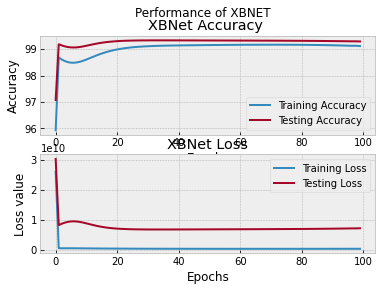

In [23]:
m, acc, lo, val_ac, val_lo = run_XBNET(
    X_train,
    X_valid,
    y_train,
    y_valid,
    model,
    criterion,
    optimizer,
    epochs = 100,
    batch_size = 128
)

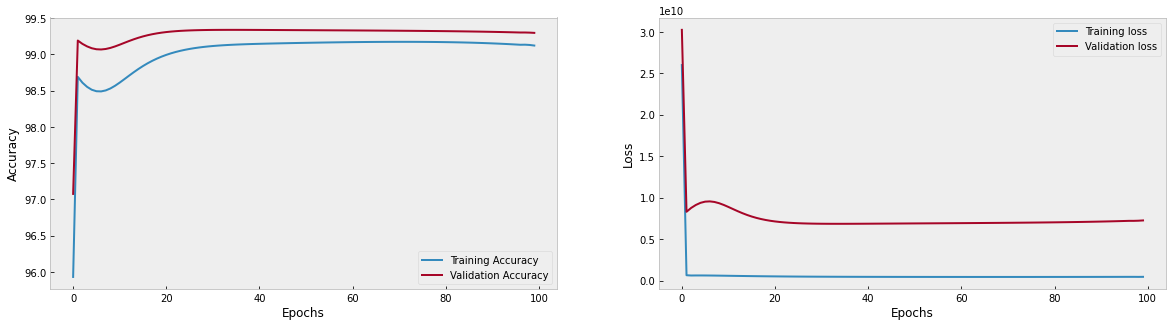

In [24]:
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(acc,label = "Training Accuracy")
plt.plot(val_ac,label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(lo,label = "Training loss")
plt.plot(val_lo,label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend() 
plt.grid()

<h1 style="color:blue">Results</h1>


In [32]:
xbnet_preds = []
for i in range(0, len(y_test)):
    xbnet_preds.append(predict(m, X_test[i, :]))

xgb_preds = xgb_reg.predict(X_test)

In [33]:
mse0 = mean_squared_error(y_test, xbnet_preds)
mse1 = mean_squared_error(y_test, xgb_preds)

print(f"{b_}MSE (XBNet): {r_}{mse0:.4f}")
print(f"{b_}MSE (XGBoost): {r_}{mse1:.4f}")

MSE (XBNet): 3209360376.5775
MSE (XGBoost): 485571192967.8670


In [35]:
mse1 > mse0

True

In [38]:
prom = np.mean([xbnet_preds, xgb_preds], axis = 0)

array([   8402.695, 1532243.2  ,   35541.668, ...,  353586.5  ,
       1431184.1  , 1321474.9  ], dtype=float32)

In [39]:
test["xgb_preds"] = xgb_preds
test["xbnet_preds"] = xbnet_preds
test["prom"] = prom

df_new = pd.concat([train, test], sort = False)

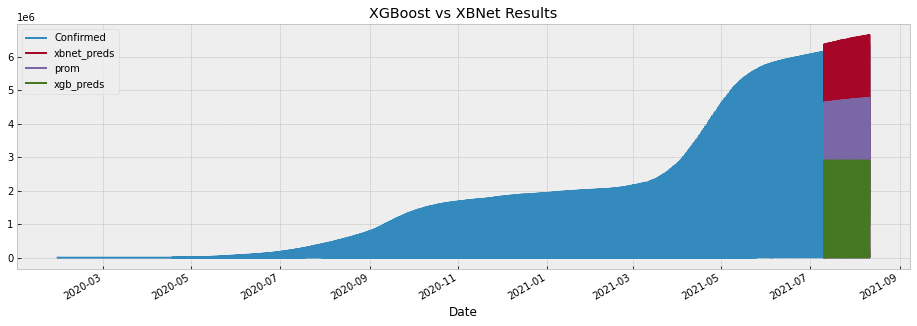

In [43]:
df_new[["Confirmed", "xbnet_preds", "prom", "xgb_preds"]].plot(figsize = (16, 5), title = "XBNet vs XGBoost Results");